In [2]:
import itertools
import sys,os
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.2, rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [5]:
import mdtraj as md

In [6]:
import pandas as pd

In [7]:
contacts_qm_df = pd.read_csv("contacts_qm_df.csv")
contacts_qm_df

,Unnamed: 0,pdb,dmean,dmin,theta,theta1,theta2
0,0,ArgPhe,0.364952,0.340676,0.172121,0.386093,0.547266
1,1,LysTyr,0.419565,0.334311,NaN,0.854846,NaN
2,2,ArgPheT,0.405896,0.336983,1.541393,0.124926,1.514827
3,3,LysPhe,0.323791,0.345352,NaN,0.057300,NaN
4,4,ArgTyrT,0.431030,0.335830,1.365738,0.526130,1.339233
5,5,ArgTyrP,0.351516,0.343716,0.039236,0.346643,0.385378
6,6,ArgTyr,0.528022,0.367168,1.491288,1.523842,1.039782


# $\pi$-stacking 

In [8]:
def unit_normal_vector(v1, v2):
    """Calculates the unit normal vector to a plane defined by two vectors.

    Args:
        v1: The first vector defining the plane.
        v2: The second vector defining the plane.

    Returns:
        The unit normal vector to the plane.
    """

    normal = np.cross(v1, v2, axisa=1)
    norm = np.linalg.norm(normal, axis=1).reshape(np.shape(normal)[0],1)
    normal = normal / norm
    return normal

In [9]:
def get_normal(coords, id, sidechain_atoms):
    """
    Calculate the normal vector to the plane defined by three atoms

    Parameters
    ----------
        coords: 
            The coordinates of the atoms
    Returns
    -------
        normal: 
            The normal vector to the plane defined by the three atoms

    """
    try: 
        i, j, k = [x.index for x in coords.topology.residue(id).atoms if x.name in sidechain_atoms]
        displacements = md.compute_displacements(coords, [[i,j], [i,k]])
        normal = unit_normal_vector(displacements[:,0,:], displacements[:,1,:])
        return normal
    except ValueError as e:
        return None

500000.0 10527
500000.0 11251
500000.0 11251


/tmp/ipykernel_1011590/2633019675.py:53: RuntimeWarning: invalid value encountered in arccos
  theta.append(np.min([np.arccos((normalY[i]*normalR).sum(1)),\
/tmp/ipykernel_1011590/2633019675.py:54: RuntimeWarning: invalid value encountered in arccos
  np.arccos((normalY[i]*-normalR).sum(1))], axis=0))


500000.0 11001


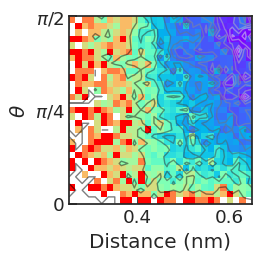

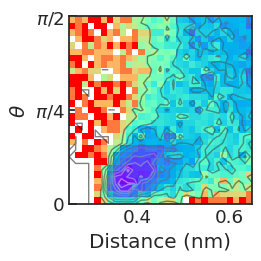

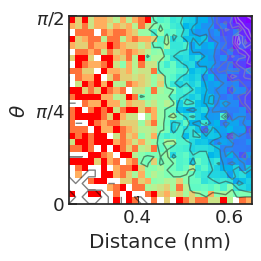

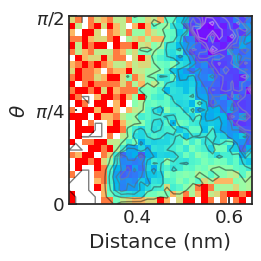

In [10]:
contact_map = {}
time = {}
soup = 'soup'

contact_map = {}
for ions in ['phys', 'neutral']: 
    time[ions] = {}
    contact_map[ions] = {}
    for lmbd in [0,1]:
        gro = "../data/GGKGG_%s_XXXL_amber99sb-star-ildn_tip3p_%s_l%i_nvt.gro"%(soup, ions, lmbd)
        xtc = "../data/GGKGG_%s_XXXL_amber99sb-star-ildn_tip3p_%s_l%i_npt_proc.xtc"%(soup, ions, lmbd)
        traj = md.load_xtc(xtc, top=gro, stride=4)
        traj = traj[1250:]
        #traj = traj[1000:]
        print (traj.time[0], traj.n_frames)

        # Calculate vector normal to the K2R residue
        K2R = [x.index for x in list(traj.topology.residues) \
                if (x.name=='K2R')]
        DNH1 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='DNH1' and x.residue.name =='K2R')][0]
        DNH2 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='DNH2' and x.residue.name =='K2R')][0]
        NZ = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='NZ' and x.residue.name =='K2R')][0]
        i,j,k = (DNH1, DNH2, NZ)
        displacements = md.compute_displacements(traj, [[i,j], [i,k]]) # bond vector
        normalR = unit_normal_vector(displacements[:,0,:], displacements[:,1,:]) # normal vector

        # Find tyrosines
        TYR = [x.index for x in list(traj.topology.residues) \
                if (x.name=='TYR')]

        # Get vectors normal to the Y plane

        # Get indexes for the first three atoms in the ring
        CG = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CG' and x.residue.name =='TYR')]
        CD1 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CD1' and x.residue.name =='TYR')]
        CD2 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CD2' and x.residue.name =='TYR')]       

        normalY = []
        for i,j,k in list(zip(CG,CD1,CD2)):
            displacements = md.compute_displacements(traj, [[i,j], [i,k]]) # bond vector
            normalY.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:])) # normal vector
        normalY = np.array(normalY)

        #  Get angle between vectors normal to R and Y
        theta = []
        for i in range(len(TYR)):
            theta.append(np.min([np.arccos((normalY[i]*normalR).sum(1)),\
                        np.arccos((normalY[i]*-normalR).sum(1))], axis=0))
        theta = np.array(theta)
            
        # Calculate theta1 and theta2 (Infield et al, JMB, 2021. DOI: 10.1016/j.jmb.2021.167035)
        ring_dist = []
        theta1 = []
        theta2 = []       

        j = K2R[0]
        j_index =  [x.index for x in traj.topology.residue(j).atoms if
                    x.name in ['DNH1', 'DNH2', 'NZ']]
        
        for k, i in enumerate(TYR):
            #print (list(traj.topology.residue(i).atoms))
            i_index =  [x.index for x in traj.topology.residue(i).atoms if
                    x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']] 
            
            displacements = md.compute_displacements(traj, \
                    list(itertools.product(i_index, j_index)))
            dvec = np.mean(displacements, axis=1)
            dvec_mod = np.linalg.norm(dvec, axis=1)
            ring_dist.append(dvec_mod)
            dvec_unit = dvec/dvec_mod.reshape(dvec_mod.shape[0],1)
            
            theta1.append(np.min([np.arccos((normalY[k]*dvec_unit).sum(axis=1)), \
                                        np.arccos((-normalY[k]*dvec_unit).sum(axis=1))],\
                                        axis=0))
            
            theta2.append(np.min([np.arccos((normalR*dvec_unit).sum(axis=1)), \
                                        np.arccos((-normalR*dvec_unit).sum(axis=1))],\
                                        axis=0))
        ring_dist = np.array(ring_dist)
        theta1 = np.array(theta1)
        theta2 = np.array(theta2)

        sel = np.array(ring_dist) < 0.65 # select only close contacts

        fig, ax = plt.subplots(figsize=(2.85, 2.85))
        nbins=30
        counts, xbins, ybins, image = ax.hist2d(ring_dist[sel], theta[sel], \
                        bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi/2, nbins)), \
                            norm=LogNorm(), cmap='rainbow_r')
        ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

        ax.set_yticks(np.linspace(0,np.pi/2,3)); ax.set_yticklabels([0, r"$\pi/4$", r"$\pi/2$"])        
        ax.set_xlabel('Distance (nm)')
        ax.set_ylabel(r'$\theta$')
        plt.tight_layout()
        plt.savefig('figures/gsy_pipi_%s_l%i.png'%(ions, lmbd), dpi=300, transparent=True)
        continue

        fig, ax = plt.subplots(figsize=(2.85, 2.85))
        nbins=30
        counts, xbins, ybins, image = ax.hist2d(ring_dist[sel], theta1[sel], \
                        bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi/2, nbins)), \
                        norm=LogNorm(), cmap='YlOrBr')
        ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

        if lmbd == 0:
            selqm = contacts_qm_df['pdb'].str.contains('LysTyr')
        elif lmbd==1:
            selqm = contacts_qm_df['pdb'].str.contains('ArgTyr')
        sns.scatterplot(data=contacts_qm_df[selqm], x='dmean', y='theta1', \
                style='pdb', color='green', s=50, edgecolors='k', linewidth=1.5)
        plt.legend(title=None, fontsize=10)
        plt.legend([], frameon=False)

        ax.set_yticks(np.linspace(0,np.pi/2,3)); ax.set_yticklabels([0, r"$\pi/4$", r"$\pi/2$"])        
        ax.set_xlabel('Distance (nm)')
        ax.set_ylabel(r'$\theta_1$')
        plt.tight_layout()
        plt.savefig('figures/gsy_pipi_%s_l%i_d_vs_theta1.png'%(ions, lmbd), dpi=300, transparent=True)

        fig, ax = plt.subplots(figsize=(2.85, 2.85))
        nbins=30
        counts, xbins, ybins, image = ax.hist2d(ring_dist[sel], theta2[sel], \
                        bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi/2, nbins)), \
                            norm=LogNorm(), cmap='YlOrBr')
        ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)
        if lmbd == 0:
            selqm = contacts_qm_df['pdb'].str.contains('LysTyr')
        elif lmbd==1:
            selqm = contacts_qm_df['pdb'].str.contains('ArgTyr')
        sns.scatterplot(data=contacts_qm_df[selqm], x='dmean', y='theta2', \
                style='pdb', color='green', s=50, edgecolors='k', linewidth=1.5)
        plt.legend(title=None, fontsize=10)
        plt.legend([], frameon=False)

        ax.set_yticks(np.linspace(0,np.pi/2,3)); ax.set_yticklabels([0, r"$\pi/4$", r"$\pi/2$"])        
        ax.set_xlabel('Distance (nm)')
        ax.set_ylabel(r'$\theta_2$')
        plt.tight_layout()
        plt.savefig('figures/gsy_pipi_%s_l%i_d_vs_theta2.png'%(ions, lmbd), dpi=300, transparent=True)

        fig, ax = plt.subplots(figsize=(3,3))
        nbins=30
        counts, xbins, ybins, image = ax.hist2d(theta2[sel], theta1[sel], \
                        bins=(np.linspace(0., np.pi/2, nbins), np.linspace(0, np.pi/2, nbins)), \
                            norm=LogNorm(), cmap='YlOrBr')
        ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)
        if lmbd == 0:
            selqm = contacts_qm_df['pdb'].str.contains('LysTyr')
        elif lmbd==1:
            selqm = contacts_qm_df['pdb'].str.contains('ArgTyr')
        sns.scatterplot(data=contacts_qm_df[selqm], x='theta1', y='theta2', \
                style='pdb', color='green', s=50, edgecolors='k', linewidth=1.5)
        plt.legend(title=None, fontsize=10)
        plt.legend([], frameon=False)
        ax.set_xticks(np.linspace(0,np.pi/2,3)); ax.set_xticklabels([0, r"$\pi/4$", r"$\pi/2$"])        
        ax.set_yticks(np.linspace(0,np.pi/2,3)); ax.set_yticklabels([0, r"$\pi/4$", r"$\pi/2$"])        
        ax.set_xlabel(r'$\theta_1$')
        ax.set_ylabel(r'$\theta_2$')
        plt.tight_layout()
        plt.savefig('figures/gsy_pipi_%s_l%i_theta1_vs_theta2.png'%(ions, lmbd), dpi=300, transparent=True)
#        stacked = []
#        for i,Y in enumerate(TYR):
#            sel = np.logical_and(ring_dist[i] < 0.45, \
#                        np.abs(theta[i] - np.pi/2) > 1)
#            if np.any(sel):
#                atom_select = list([atom.index for atom in traj.top.residue(Y).atoms]) + \
#                        list([atom.index for atom in traj.top.residue(K2R[0]).atoms])
#                stacked.append(traj[sel].atom_slice(atom_select))
#        stacked_all = md.join(stacked)
#        stacked_all.center_coordinates()
#        stacked_all.save('gsy_pipi_%s_l%i.gro'%(ions, lmbd))

400000.0 8001
400000.0 8001
400000.0 8001
400000.0 8001


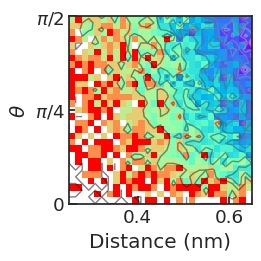

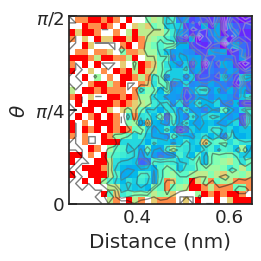

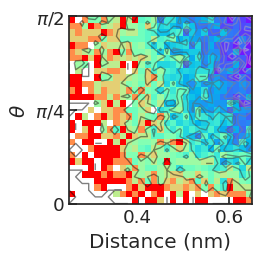

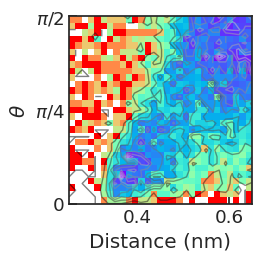

In [12]:
contact_map = {}
time = {}
soup = 'soupF'

contact_map = {}
for ions in ['phys', 'neutral']: 
    time[ions] = {}
    contact_map[ions] = {}
    for lmbd in [0,1]:
        gro = "../data/GGKGG_%s_XXXL_amber99sb-star-ildn_tip3p_%s_l%i_nvt.gro"%(soup, ions, lmbd)
        xtc = "../data/GGKGG_%s_XXXL_amber99sb-star-ildn_tip3p_%s_l%i_npt_proc.xtc"%(soup, ions, lmbd)
        traj = md.load_xtc(xtc, top=gro, stride=2)
        traj = traj[2000:]
        print (traj.time[0], traj.n_frames)

        # Calculate vector normal to the K2R residue
        K2R = [x.index for x in list(traj.topology.residues) \
                if (x.name=='K2R')]
        DNH1 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='DNH1' and x.residue.name =='K2R')][0]
        DNH2 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='DNH2' and x.residue.name =='K2R')][0]
        NZ = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='NZ' and x.residue.name =='K2R')][0]
        i,j,k = (DNH1, DNH2, NZ)
        displacements = md.compute_displacements(traj, [[i,j], [i,k]]) # bond vector
        normalR = unit_normal_vector(displacements[:,0,:], displacements[:,1,:]) # normal vector

        # Find phenylalanines 
        PHE = [x.index for x in list(traj.topology.residues) \
                if (x.name=='PHE')]

        # Get vectors normal to the Y plane

        # Get indexes for the first three atoms in the ring
        CG = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CG' and x.residue.name =='PHE')]
        CD1 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CD1' and x.residue.name =='PHE')]
        CD2 = [x.index for x in list(traj.topology.atoms) \
            if (x.name=='CD2' and x.residue.name =='PHE')]       

        normalF = []
        for i,j,k in list(zip(CG,CD1,CD2)):
            displacements = md.compute_displacements(traj, [[i,j], [i,k]]) # bond vector
            normalF.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:])) # normal vector
        normalF = np.array(normalF)

        #  Get angle between vectors normal to R and Y
        theta = []
        for i in range(len(PHE)):
            theta.append(np.min([np.arccos((normalF[i]*normalR).sum(1)),\
                        np.arccos((normalF[i]*-normalR).sum(1))], axis=0))
        theta = np.array(theta)
            
        # Calculate theta1 and theta2 (Infield et al, JMB, 2021. DOI: 10.1016/j.jmb.2021.167035)
        ring_dist = []
        theta1 = []
        theta2 = []       

        j = K2R[0]
        j_index =  [x.index for x in traj.topology.residue(j).atoms if
                    x.name in ['DNH1', 'DNH2', 'NZ']]
        
        for k, i in enumerate(PHE):
            #print (list(traj.topology.residue(i).atoms))
            i_index =  [x.index for x in traj.topology.residue(i).atoms if
                    x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']] 
            
            displacements = md.compute_displacements(traj, \
                    list(itertools.product(i_index, j_index)))
            dvec = np.mean(displacements, axis=1)
            dvec_mod = np.linalg.norm(dvec, axis=1)
            ring_dist.append(dvec_mod)
            dvec_unit = dvec/dvec_mod.reshape(dvec_mod.shape[0],1)
            
            theta1.append(np.min([np.arccos((normalF[k]*dvec_unit).sum(axis=1)), \
                                        np.arccos((-normalF[k]*dvec_unit).sum(axis=1))],\
                                        axis=0))
            
            theta2.append(np.min([np.arccos((normalR*dvec_unit).sum(axis=1)), \
                                        np.arccos((-normalR*dvec_unit).sum(axis=1))],\
                                        axis=0))
        ring_dist = np.array(ring_dist)
        theta1 = np.array(theta1)
        theta2 = np.array(theta2)

        sel = np.array(ring_dist) < 0.65 # select only close contacts

        fig, ax = plt.subplots(figsize=(2.85, 2.85))
        nbins=30
        counts, xbins, ybins, image = ax.hist2d(ring_dist[sel], theta[sel], \
                        bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi/2, nbins)), \
                            norm=LogNorm(), cmap='rainbow_r')
        ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

        ax.set_yticks(np.linspace(0,np.pi/2,3)); ax.set_yticklabels([0, r"$\pi/4$", r"$\pi/2$"])        
        ax.set_xlabel('Distance (nm)')
        ax.set_ylabel(r'$\theta$')
        plt.tight_layout()
        plt.savefig('figures/gsf_pipi_%s_l%i.png'%(ions, lmbd), dpi=300, transparent=True)
        continue
    
        fig, ax = plt.subplots(figsize=(2.85, 2.85))
        nbins=30
        counts, xbins, ybins, image = ax.hist2d(ring_dist[sel], theta1[sel], \
                        bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi/2, nbins)), \
                        norm=LogNorm(), cmap='YlOrBr')
        ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

        if lmbd == 0:
            selqm = contacts_qm_df['pdb'].str.contains('LysPhe')
            sns.scatterplot(data=contacts_qm_df[selqm], x='dmean', y='theta1', \
                style='pdb', color='darkviolet', s=50, edgecolors='k', linewidth=1.5)
        elif lmbd==1:
            selqm = contacts_qm_df['pdb'].str.contains('ArgPhe')
            sns.scatterplot(data=contacts_qm_df[selqm], x='dmean', y='theta1', \
                style='pdb', color='darkviolet', s=50, edgecolors='k', linewidth=1.5, markers=["X", "o"])
        plt.legend(title=None, fontsize=10)
        plt.legend([], frameon=False)

        ax.set_xlim(0.25, 0.65)
        ax.set_yticks(np.linspace(0,np.pi/2,3)); ax.set_yticklabels([0, r"$\pi/4$", r"$\pi/2$"])        
        ax.set_xlabel('Distance (nm)')
        ax.set_ylabel(r'$\theta_1$')
        plt.tight_layout()
        plt.savefig('figures/gsf_pipi_%s_l%i_d_vs_theta1.png'%(ions, lmbd), dpi=300, transparent=True)

        fig, ax = plt.subplots(figsize=(2.85, 2.85))
        nbins=30
        counts, xbins, ybins, image = ax.hist2d(ring_dist[sel], theta2[sel], \
                        bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi/2, nbins)), \
                            norm=LogNorm(), cmap='YlOrBr')
        ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)
        if lmbd == 0:
            selqm = contacts_qm_df['pdb'].str.contains('LysPhe')
            sns.scatterplot(data=contacts_qm_df[selqm], x='dmean', y='theta2', \
                style='pdb', color='darkviolet', s=50, edgecolors='k', linewidth=1.5)
        elif lmbd==1:
            selqm = contacts_qm_df['pdb'].str.contains('ArgPhe')
            sns.scatterplot(data=contacts_qm_df[selqm], x='dmean', y='theta2', \
                style='pdb', color='darkviolet', s=50, edgecolors='k', linewidth=1.5, markers=["X", "o"])
        plt.legend(title=None, fontsize=10)
        plt.legend([], frameon=False)

        ax.set_xlim(0.25, 0.65)
        ax.set_yticks(np.linspace(0,np.pi/2,3)); ax.set_yticklabels([0, r"$\pi/4$", r"$\pi/2$"])        
        ax.set_xlabel('Distance (nm)')
        ax.set_ylabel(r'$\theta_2$')
        plt.tight_layout()
        plt.savefig('figures/gsf_pipi_%s_l%i_d_vs_theta2.png'%(ions, lmbd), dpi=300, transparent=True)

        fig, ax = plt.subplots(figsize=(3,3))
        nbins=30
        counts, xbins, ybins, image = ax.hist2d(theta2[sel], theta1[sel], \
                        bins=(np.linspace(0., np.pi/2, nbins), np.linspace(0, np.pi/2, nbins)), \
                            norm=LogNorm(), cmap='YlOrBr')
        ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)
        if lmbd == 0:
            selqm = contacts_qm_df['pdb'].str.contains('LysPhe')
            sns.scatterplot(data=contacts_qm_df[selqm], x='theta1', y='theta2', \
                style='pdb', color='darkviolet', s=50, edgecolors='k', linewidth=1.5)            
        elif lmbd==1:
            selqm = contacts_qm_df['pdb'].str.contains('ArgPhe')
            sns.scatterplot(data=contacts_qm_df[selqm], x='theta1', y='theta2', \
                style='pdb', color='darkviolet', s=50, edgecolors='k', linewidth=1.5, markers=["X", "o"])
        plt.legend(title=None, fontsize=10)
        plt.legend([], frameon=False)
        ax.set_xticks(np.linspace(0,np.pi/2,3)); ax.set_xticklabels([0, r"$\pi/4$", r"$\pi/2$"])        
        ax.set_yticks(np.linspace(0,np.pi/2,3)); ax.set_yticklabels([0, r"$\pi/4$", r"$\pi/2$"])        
        ax.set_xlabel(r'$\theta_1$')
        ax.set_ylabel(r'$\theta_2$')
        plt.tight_layout()
        plt.savefig('figures/gsf_pipi_%s_l%i_theta1_vs_theta2.png'%(ions, lmbd), dpi=300, transparent=True)
#        stacked = []
#        for i,F in enumerate(PHE):
#            sel = np.logical_and(ring_dist[i] < 0.45, \
#                        np.abs(theta[i] - np.pi/2) > 1)
#            if np.any(sel):
#                atom_select = list([atom.index for atom in traj.top.residue(F).atoms]) + \
#                        list([atom.index for atom in traj.top.residue(K2R[0]).atoms])
#                stacked.append(traj[sel].atom_slice(atom_select))
#        stacked_all = md.join(stacked)
#        stacked_all.center_coordinates()
#        stacked_all.save('gsf_pipi_%s_l%i.gro'%(ions, lmbd))

In [27]:
traj.time[0],traj.time[-1]

(1000000.0, 2000000.0)

/tmp/ipykernel_959857/1591055455.py:11: UserWarning: The markers list has more values (3) than needed (2), which may not be intended.
  s = sns.scatterplot(data=contacts_qm_df[sel], x='dmean', y='theta1', \


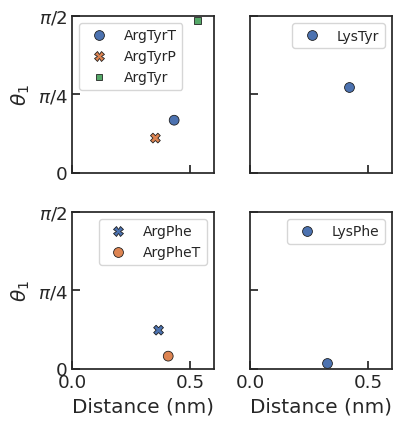

In [22]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(4.25,4.5))

sel = contacts_qm_df['pdb'].str.contains('ArgTyr')
contacts_qm_df[sel]
s = sns.scatterplot(data=contacts_qm_df[sel], x='dmean', y='theta1', \
                hue='pdb', style='pdb', s=50, edgecolors='k', ax=ax[0][0])
ax[0][0].legend(title=None , fontsize=10, loc=2)

sel = contacts_qm_df['pdb'].str.contains('ArgPhe')
contacts_qm_df[sel]
s = sns.scatterplot(data=contacts_qm_df[sel], x='dmean', y='theta1', \
                hue='pdb', style='pdb', s=50, edgecolors='k', ax=ax[1][0], markers=["X", "o", "s"])
ax[1][0].legend(title=None , fontsize=10)

sel = contacts_qm_df['pdb'].str.contains('LysTyr')
contacts_qm_df[sel]
s = sns.scatterplot(data=contacts_qm_df[sel], x='dmean', y='theta1', \
                hue='pdb', style='pdb', s=50, edgecolors='k', ax=ax[0][1])
ax[0][1].legend(title=None , fontsize=10)

sel = contacts_qm_df['pdb'].str.contains('LysPhe')
contacts_qm_df[sel]
s = sns.scatterplot(data=contacts_qm_df[sel], x='dmean', y='theta1', \
                hue='pdb', style='pdb', s=50, edgecolors='k', ax=ax[1][1])
ax[1][1].legend(title=None , fontsize=10)

ax[0][0].set_xlim(0,0.6)
ax[0][0].set_ylim(0,np.pi/2)
ax[0][0].set_yticks(np.linspace(0,np.pi/2,3))
ax[0][0].set_yticklabels([0, r"$\pi/4$", r"$\pi/2$"])        
ax[1][0].set_yticklabels([0, r"$\pi/4$", r"$\pi/2$"])        

ax[1][0].set_xlabel('Distance (nm)')
ax[1][1].set_xlabel('Distance (nm)')
ax[1][0].set_ylabel(r'$\theta_1$')
ax[0][0].set_ylabel(r'$\theta_1$')
plt.tight_layout()